In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
%matplotlib inline


In [5]:
import matplotlib.pyplot as plt
import os
import numpy as np
import fnmatch
import sys
import math
import matplotlib as mpl
import matplotlib.lines as mlines

cap = 15


In [7]:
# This class read each line and returns array
class GetPerformanceInfo():
    def __init__(self):
        # just for drawing
        self.exp_names = {}

        # For non-time stats of despot
        self.list_moped_steps = [] # A list per exp (each list is per file, each number in this list is moped steps per tree construction)
        self.list_trials_tree_search = [] # A list per exp (each list is per file, each number in a list is the trials for 1 tree search)
        self.list_node_expansions = [] # A list of list per exp (each number in a list is the number of roll outs for 1 tree search)
        self.list_nodes = [] # A list of list per exp (each number in a list is the number of nodes of 1 tree)
        self.list_tree_depth = [] # A list of list per exp (each number in a list is the number of depth of 1 tree)
        self.list_actions = [] # A list of number per exp (the number of action per scenario)
        # For time stats of despot
        self.list_tree_search_times = [] # A list of list per exp (each number in a list is the time for 1 tree search, equal to time for 1 action search)
        self.list_run_time_one_scenario = [] # A list of number per file (each number is the time for 1 scenario)
        self.list_moped_time = [] # A list of list per file (each number in a list is the time for 1 moped step)

        # For performance
        self.collision_counts_per_folder = 0 # A number per experiment, +1 if a file in folder got collision
        self.file_counts_per_folder = 0
        self.success_counts_per_folder = 0
        self.acc_counts = []
        self.list_progrest_dists = []
        self.list_traveled_dist = []
        self.list_rewards = []
        self.list_speeds = []

        # Reward performance
        self.prediction_rewards = {'goal':[], 'collision':[], 'smooth':[], 'speed':[]} # A list of list, length of inner list = many
        self.step_rewards = {'goal':[], 'collision':[], 'smooth':[], 'speed':[]} # A list of list, length of inner list = number actions


        self.reset_per_file_variables()

    def reset_per_file_variables(self):
        # these variables is for reading each file
        self.total_moped_step = [] # A list per file
        self.total_tree_search_time = [] # A list per file
        self.total_trials_tree_search = [] # A list per file (each number in a list is the trials for 1 tree search)
        self.total_tree_depth = [] # A list per file (each number in a list is the number of depth of 1 tree)
        self.total_node_expansions = [] # A list per file (each number in a list is the number of roll outs for 1 tree search)
        self.total_nodes = [] # A list per file (each number in a list is the number of nodes of 1 tree)
        self.moped_prediction_time = []
        self.run_time_one_scenario = 0 # A number per file (the time for 1 scenario)
        self.acceleration_count = 0
        self.maintain_count = 0
        self.deceleration_count = 0
        self.rewards = []
        self.speeds = []
        self.last_pos = None
        self.last_speed = 0.0
        self.travelled_dist = 0
        self.progress_dist = 0
        self.progress_dists = []
        self.collision_flag = False
        self.reach_goal_flag = False
        self.total_steps_per_tree_construction_per_file = 0 # to find self.total_moped_step
        self.data_pos = {}
        self.cur_step = 0
        self.execution_step = 0
        self.reading_tree = False
        self.start_reading = False
        self.sub_prediction_reward = {'goal': [], 'collision': [], 'smooth': [], 'speed': []}  # A list of number
        self.sub_step_reward = {'goal': [], 'collision': [], 'smooth': [], 'speed': []}  # A list of number

        self.new_read = True


    def read(self, line):
        # Resetting for a new file
        if self.new_read:
            self.reset_per_file_variables()
            self.new_read = False
            self.file_counts_per_folder += 1

        if 'Construct tree' in line:
            self.start_reading = True  # to start reading from beginning

        if self.start_reading and "ContextPomdp::Step 123" in line:
            self.total_steps_per_tree_construction_per_file += 1

        if "deleting tree" in line:
            self.total_moped_step.append(self.total_steps_per_tree_construction_per_file)
            self.total_steps_per_tree_construction_per_file = 0

        if "[RunStep] Time spent in N6despot6DESPOTE::Search()" in line:
            self.total_tree_search_time.append(float(line.split(' ')[-1]))

        if "Trials: no." in line:
            self.total_trials_tree_search.append(int(line.split(' ')[6]))
            self.total_tree_depth.append(int(line.split(' ')[8]))

        if "# nodes: expanded" in line:
            self.total_node_expansions.append(int(line.split(' ')[8]))
            self.total_nodes.append(int(line.split(' ')[10]))

        if "All MopedPred Time" in line:
            try:
                self.moped_prediction_time.append(float(line.split(' ')[6]))
            except:
                pass

        if "Round 0 Step" in line:
            self.execution_step = int(line.split()[-1].split('-')[0])

        if "ExecuteAction at the" in line:
            self.run_time_one_scenario = float(line.split()[4][:-2])

        if 'executing step' in line:
            line_1 = line.split('executing step ', 1)[1]
            self.cur_step = int(line_1.split('=', 1)[0])
        elif 'Round 0 Step' in line:
            line_1 = line.split('Round 0 Step ', 1)[1]
            self.cur_step = int(line_1.split('-', 1)[0])
        elif 'goal reached at step' in line:
            line_1 = line.split('goal reached at step ', 1)[1]
            self.cur_step = int(line_1.split(' ', 1)[0])
        elif 'action **=' in line:
            acc = int(line.split(' ')[2]) % 3
            if acc == 1:
                self.acceleration_count += 1
            elif acc == 0:
                self.maintain_count += 1
        elif 'reward **=' in line:
            if self.cur_step >= cap:
                self.rewards.append(float(line.split(' ')[2]))
        elif "car pos / heading / vel" in line:
            # = (149.52, 171.55) / 1.3881 / 0.50245
            speed = float(line.split(' ')[12])
            pos_x = float(line.split(' ')[7].replace('(', '').replace(',', ''))
            pos_y = float(line.split(' ')[8].replace(')', '').replace(',', ''))
            if self.cur_step >= cap:
                self.speeds.append(speed)
            pos = [pos_x, pos_y]

            if self.last_pos:
                self.travelled_dist += math.sqrt((pos[0] - self.last_pos[0]) ** 2 + (pos[1] - self.last_pos[1]) ** 2)
                self.progress_dist += math.sqrt((pos[0] - self.last_pos[0]) ** 2 + (pos[1] - self.last_pos[1]) ** 2)
            self.last_pos = pos

            if self.cur_step >= cap:
                if self.last_speed > 2.0 and speed < 0.2:
                    self.progress_dists.append(self.progress_dist)
                    self.progress_dist = 0.0

            if speed < self.last_speed - 0.2:
                self.deceleration_count += 1
            self.last_speed = speed

            if "av" in self.data_pos:
                val = self.data_pos["av"]
                val[self.cur_step] = pos
            else:
                self.data_pos["av"] = {self.cur_step: pos}
        elif "id / pos / speed / vel" in line:
            agentid = int(line.split()[16].replace('(', '').replace(',', ''))
            pos_x = float(line.split()[18].replace('(', '').replace(',', ''))
            pos_y = float(line.split()[19].replace(')', '').replace(',', ''))
            pos = [pos_x, pos_y]

            if f"agent{agentid}" in self.data_pos:
                val = self.data_pos[f"agent{agentid}"]
                val[self.cur_step] = pos
            else:
                self.data_pos[f"agent{agentid}"] = {self.cur_step: pos}

        if 'goal reached' in line:
            self.reach_goal_flag = True
            self.success_counts_per_folder += 1

        if ('collision = 1' in line or 'INININ' in line or 'in real collision' in line)\
                and self.reach_goal_flag == False:
            self.collision_flag = True
            self.collision_counts_per_folder += 1

        if "smooth-reward" in line:
            if "WorldSimulator::StepReward" in line:
                self.sub_step_reward['smooth'].append(float(line.split(' ')[-1]))
            elif "ContextPomdp::Step 123" in line:
                self.sub_prediction_reward['smooth'].append(float(line.split(' ')[-1]))
        if "crash-reward" in line:
            if "WorldSimulator::StepReward" in line:
                self.sub_step_reward['collision'].append(float(line.split(' ')[-1]))
            elif "ContextPomdp::Step 123" in line:
                self.sub_prediction_reward['collision'].append(float(line.split(' ')[-1]))
        if "goal-reward" in line:
            if "WorldSimulator::StepReward" in line:
                self.sub_step_reward['goal'].append(float(line.split(' ')[-1]))
            elif "ContextPomdp::Step 123" in line:
                self.sub_prediction_reward['goal'].append(float(line.split(' ')[-1]))
        if "speed-reward" in line:
            if "WorldSimulator::StepReward" in line:
                self.sub_step_reward['speed'].append(float(line.split(' ')[-1]))
            elif "ContextPomdp::Step 123" in line:
                self.sub_prediction_reward['speed'].append(float(line.split(' ')[-1]))



    def finish(self, exp_name):
        self.new_read = True

        # Resetting for a new experiment folder
        if exp_name not in self.exp_names.keys():
            # For non-time stats of despot
            self.list_moped_steps = [] # A list per exp (each list is per file, each number in this list is moped steps per tree construction)
            self.list_trials_tree_search = [] # A list per exp (each list is per file, each number in a list is the trials for 1 tree search)
            self.list_node_expansions = [] # A list of list per exp (each number in a list is the number of roll outs for 1 tree search)
            self.list_nodes = [] # A list of list per exp (each number in a list is the number of nodes of 1 tree)
            self.list_tree_depth = [] # A list of list per exp (each number in a list is the number of depth of 1 tree)
            self.list_actions = [] # A list of number per exp (the number of action per scenario)
            # For time stats of despot
            self.list_tree_search_times = [] # A list of list per exp (each number in a list is the time for 1 tree search, equal to time for 1 action search)
            self.list_run_time_one_scenario = [] # A list of number per file (each number is the time for 1 scenario)
            self.list_moped_time = [] # A list of list per file (each number in a list is the time for 1 moped step)

            # For performance
            self.collision_counts_per_folder = 0 # A number per experiment, +1 if a file in folder got collision
            self.file_counts_per_folder = 0
            self.success_counts_per_folder = 0
            self.acc_counts = []

            self.list_progrest_dists = []
            self.list_traveled_dist = []
            self.list_rewards = []
            self.list_speeds = []

            self.prediction_rewards = {'goal': [], 'collision': [], 'smooth': [],
                                       'speed': []}  # A list of list, length of inner list = many
            self.step_rewards = {'goal': [], 'collision': [], 'smooth': [],
                                 'speed': []}  # A list of list, length of inner list = number actions

        self.file_counts_per_folder += 1

        #self.exp_names.setdefault(exp_name, None)

        # 'exp': [[10,20,30], [5,10,80,70]] -> 2 files of this exp, each file has 3 and 4 tree constructions resp.
        # and there exists those moped steps per tree
        self.list_moped_steps.append(self.total_moped_step)
        self.list_trials_tree_search.append(self.total_trials_tree_search)
        self.list_node_expansions.append(self.total_node_expansions)
        self.list_nodes.append(self.total_nodes)
        self.list_tree_depth.append(self.total_tree_depth)
        self.list_actions.append(self.execution_step)

        self.list_run_time_one_scenario.append(self.run_time_one_scenario)
        self.list_moped_time.append(self.moped_prediction_time)
        self.list_tree_search_times.append(self.total_tree_search_time)

        if self.cur_step > cap:
            # dec_count  = dec_count / float(cur_step)
            # acc_count  = acc_count / float(cur_step)
            # mat_count  = mat_count / float(cur_step)
            # dec_counts.append(dec_count)
            # acc_counts.append(acc_count)
            # mat_counts.append(mat_count)
            # if dist <= 1:
            #     stuck_counts.append(1)
            # else:
            #     stuck_counts.append(0)
            # if reach_goal_flag == True:
            #     goal_count+=1
            #     assert(cur_step != 0)
            #     goal_step.append(cur_step)
            # else:
            #     pass # print("fail file: ", txtfile)
            # if collision_flag == True:
            #     pass #col_count += 1
            #     # print("col file: ", txtfile)

            # Append the last progress_dist
            self.progress_dists.append(self.progress_dist)

            self.list_progrest_dists.append(self.progress_dists)
            self.list_traveled_dist.append(self.travelled_dist)
            self.list_rewards.append(float(np.mean(self.rewards)))
            self.list_speeds.append(float(np.mean(self.speeds)))

            for k in ['goal', 'collision', 'smooth', 'speed']:
                self.step_rewards[k].append(self.sub_step_reward[k])
                self.prediction_rewards[k].append(self.sub_prediction_reward[k])


        self.exp_names[exp_name] = {
            'moped_steps': self.list_moped_steps, # list of list
            'number_trials': self.list_trials_tree_search,# list of list
            'node_expansions': self.list_node_expansions,# list of list
            'nodes': self.list_nodes,# list of list
            'tree_depth': self.list_tree_depth,# list of list
            'number_actions': self.list_actions, # list of number

            'moped_time': self.list_moped_time, # list of list
            'tree_search_time': self.list_tree_search_times, # list of list
            'run_time_one_scenario': self.list_run_time_one_scenario, # list of number

            'progress_dists': self.list_progrest_dists, # list of list
            'traveled_dist': self.list_traveled_dist, # list of number
            'avg_rewards': self.list_rewards, # list of list
            'avg_speeds': self.list_speeds, # list of list

            'collision_counts': self.collision_counts_per_folder/self.file_counts_per_folder, # number

            'step_rewards': self.step_rewards, # list of list
            'prediction_rewards': self.prediction_rewards, # list of list
        }

    def subplot(self, exp_name, exp_name_index, what_to_plot, ax_row, ax_col, version1, axs):
        if version1:
            arrays = []
            for zz in range(len(self.exp_names[exp_name][what_to_plot])):
                arrays.append(np.mean(np.array(self.exp_names[exp_name][what_to_plot][zz])))
            axs[ax_row][ax_col].violinplot(arrays, positions=[exp_name_index],
                                 showmeans=True, showmedians=False, showextrema=False)
        else:
            ## Version 2. Get all elements
            arrays = []
            if isinstance(self.exp_names[exp_name][what_to_plot], list):
                for zz in range(len(self.exp_names[exp_name][what_to_plot])):
                    if not isinstance(self.exp_names[exp_name][what_to_plot][zz], list): # for list of number
                        arrays.append(self.exp_names[exp_name][what_to_plot][zz])
                    else: # for list of list
                        arrays.extend(self.exp_names[exp_name][what_to_plot][zz])
            else:
                arrays = [self.exp_names[exp_name][what_to_plot]]
            axs[ax_row][ax_col].violinplot(arrays, positions=[exp_name_index],
                                 showmeans=True, showmedians=False, showextrema=False)

        if what_to_plot == "moped_time":
            axs[ax_row][ax_col].text(x=exp_name_index, y=np.mean(arrays) * 1.05,
                                     s=round(float(np.mean(arrays)), 5), ha="center")
        else:
            axs[ax_row][ax_col].text(x=exp_name_index, y=np.mean(arrays) * 1.05,
                       s=round(float(np.mean(arrays)), 2), ha="center")

        print(f"exp_name: {exp_name}, what_to_plot: {what_to_plot}, mean: {np.mean(arrays)}")


    def draw(self, version1=False):

        number_of_exp = len(self.exp_names)

        fig, axs = plt.subplots(2, 4, figsize=(20,20)) # we plot 4 values so we need 2 times 2. Can be adjusted if draw more than that

        temp = [1.6920, 1.9536, 3.0997, 5.4749, 2.3718, 2.46718, 3.1474, 3.40218]

        for i in range(number_of_exp):
            key = list(self.exp_names)[i]

            print(f"key: {key}")


            self.subplot(exp_name=key, exp_name_index=i, what_to_plot='moped_steps', ax_row=0, ax_col=0, version1=version1, axs=axs)
            self.subplot(exp_name=key, exp_name_index=i, what_to_plot='number_trials', ax_row=0, ax_col=1, version1=version1, axs=axs)
            self.subplot(exp_name=key, exp_name_index=i, what_to_plot='nodes', ax_row=0, ax_col=2, version1=version1, axs=axs)
            self.subplot(exp_name=key, exp_name_index=i, what_to_plot='tree_depth', ax_row=0, ax_col=3, version1=version1, axs=axs)

            #self.subplot(exp_name=key, exp_name_index=i, what_to_plot='progress_dists', ax_row=3, ax_col=0, version1=version1, axs=axs)

            axs[1][0].violinplot([temp[i]], positions=[i],showmeans=True, showmedians=False, showextrema=False)
            axs[1][0].text(x=i, y=np.mean(temp[i]) * 1.05,
                                     s=round(float(np.mean(temp[i])), 2), ha="center")

            self.subplot(exp_name=key, exp_name_index=i, what_to_plot='avg_rewards', ax_row=1, ax_col=1, version1=version1, axs=axs)
            self.subplot(exp_name=key, exp_name_index=i, what_to_plot='avg_speeds', ax_row=1, ax_col=2, version1=version1, axs=axs)
            self.subplot(exp_name=key, exp_name_index=i, what_to_plot='collision_counts', ax_row=1, ax_col=3, version1=version1, axs=axs)


        axs[0][0].set_title("Moped steps/Tree")
        #axs[0][0].margins(y=0.1)
        axs[0][1].set_title("Trials/Tree")
        axs[0][2].set_title("Total Nodes/Tree")
        axs[0][3].set_title("Tree Depth")

        axs[1][0].set_title("ADE(K=1)")
        axs[1][1].set_title("Rewards")
        axs[1][2].set_title("Speed")
        axs[1][3].set_title("Col. rate")

        # add x-tick labels
        # plt.setp(axs, xticks=[y for y in range(len(self.exp_names))],
        #          xticklabels=["ori", "3Hz_ts01_8e4", "3Hz_ts1_8e4", "30Hz_ts1_8e4"])
        ### Get coloring
        color_lines = []
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        for i in range(len(self.exp_names.keys())):
            blue_line = mlines.Line2D([], [], color=colors[i], label=list(self.exp_names.keys())[i])
            color_lines.append(blue_line)

        #fig.legend(labels=self.exp_names.keys(), loc='center right', ncol=1, labelcolor=mpl.rcParams["axes.prop_cycle"])
        fig.legend(handles=color_lines, loc='center right', ncol=1)
        print([ax.get_legend_handles_labels() for ax in fig.axes])
        plt.setp(axs, xticks=[])
        #fig.tight_layout()
        plt.legend()
        plt.show()

100 files found in /home/phong/driving_data_pc/same_Hz/cv3hz_fixed/
NO agent array in 0 files
96 filtered files found in /home/phong/driving_data_pc/same_Hz/cv3hz_fixed/
100 files found in /home/phong/driving_data_pc/same_Hz/ca3hz_fixed/
NO agent array in 1 files
98 filtered files found in /home/phong/driving_data_pc/same_Hz/ca3hz_fixed/
100 files found in /home/phong/driving_data_pc/same_Hz/lanegcn3hz_fixed/
NO agent array in 0 files
87 filtered files found in /home/phong/driving_data_pc/same_Hz/lanegcn3hz_fixed/
100 files found in /home/phong/driving_data_pc/same_Hz/hivt3hz_fixed/
NO agent array in 0 files
93 filtered files found in /home/phong/driving_data_pc/same_Hz/hivt3hz_fixed/
100 files found in /home/phong/driving_data_pc/same_Hz/knndefault3hz_fixed/
NO agent array in 0 files
93 filtered files found in /home/phong/driving_data_pc/same_Hz/knndefault3hz_fixed/
100 files found in /home/phong/driving_data_pc/same_Hz/knnsocial3hz_fixed/
NO agent array in 0 files
86 filtered files f

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


exp_name: lstmsocial3hz_fixed, what_to_plot: tree_depth, mean: 0.2754355872528663
exp_name: lstmsocial3hz_fixed, what_to_plot: avg_rewards, mean: -2.5793533569949734
exp_name: lstmsocial3hz_fixed, what_to_plot: avg_speeds, mean: 2.106283746383389
exp_name: lstmsocial3hz_fixed, what_to_plot: collision_counts, mean: 0.10695187165775401
[([], []), ([], []), ([], []), ([], []), ([], []), ([], []), ([], []), ([], [])]


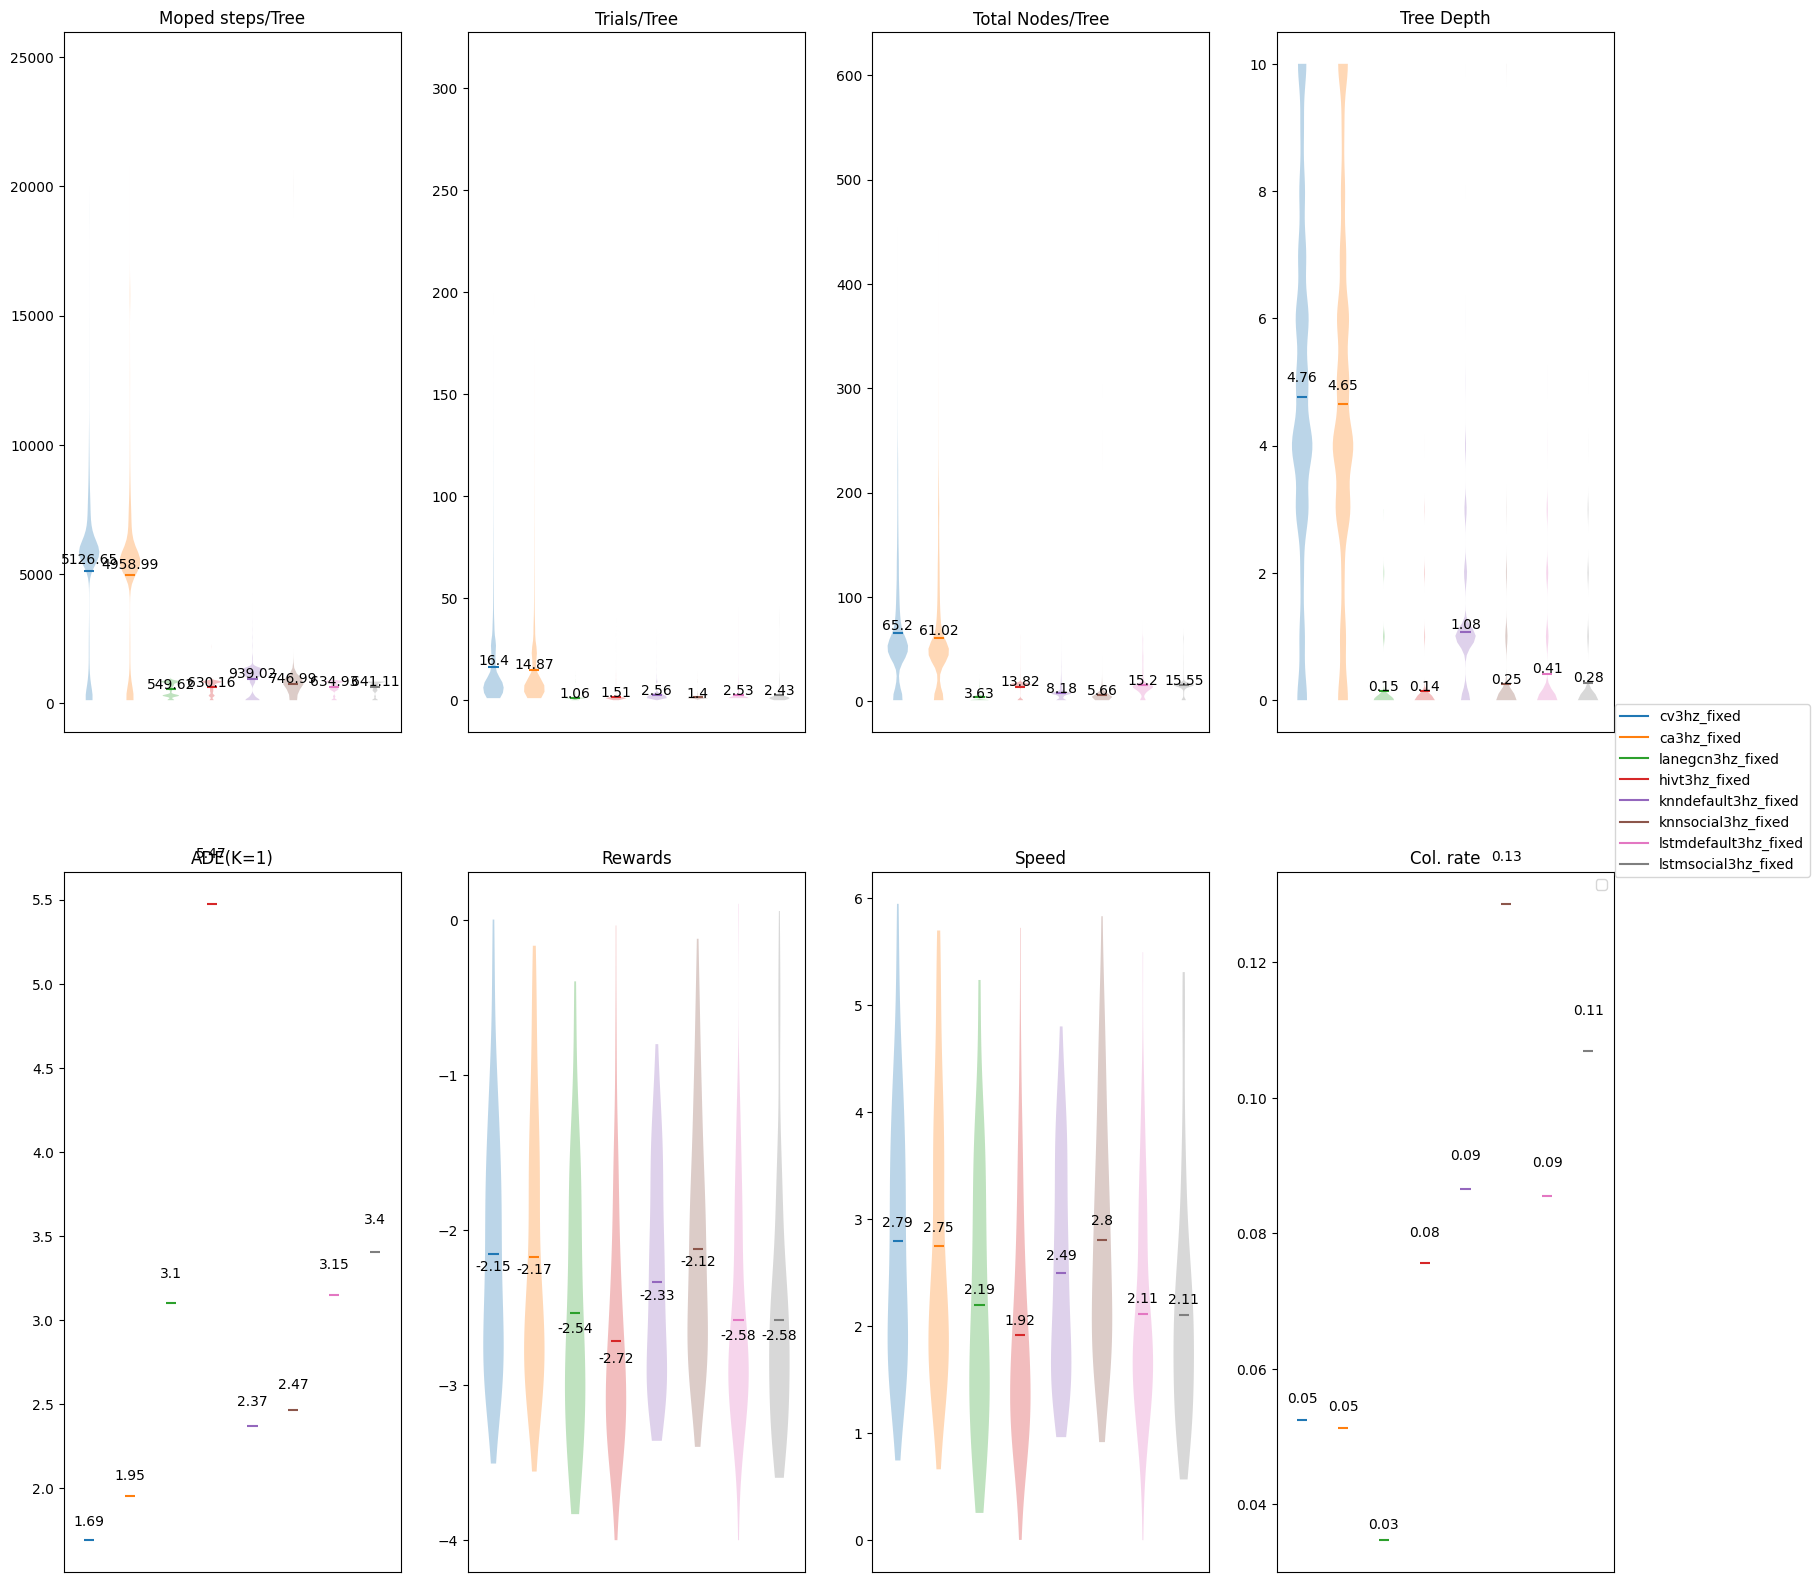

In [9]:
if __name__ == "__main__":

    FOLDER_PATHS = [

        '/home/phong/driving_data_pc/same_Hz/cv3hz_fixed/',
        '/home/phong/driving_data_pc/same_Hz/ca3hz_fixed/',
        '/home/phong/driving_data_pc/same_Hz/lanegcn3hz_fixed/',
        '/home/phong/driving_data_pc/same_Hz/hivt3hz_fixed/',
        '/home/phong/driving_data_pc/same_Hz/knndefault3hz_fixed/',
        '/home/phong/driving_data_pc/same_Hz/knnsocial3hz_fixed/',
        '/home/phong/driving_data_pc/same_Hz/lstmdefault3hz_fixed/',
        '/home/phong/driving_data_pc/same_Hz/lstmsocial3hz_fixed/',

    ]


    stats = GetPerformanceInfo()
    for folder_path in FOLDER_PATHS:
        file_path_list = filter_txt_files(folder_path,
                                      collect_txt_files(folder_path, flag="", ignore_flag="nothing"))

        experiment_name = folder_path.split('/')[5]

        # Reading 5 files for short now
        count = 0
        for file_path in file_path_list:
            with open(file_path, 'r') as f:

                for line in f.readlines():
                    stats.read(line)

            stats.finish(experiment_name)
            count += 1
            # if count == 5:
            #     break

    stats.draw()